In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import tensorflow as tf

from pathlib import Path

if 'automl/efficientnetv2' not in sys.path:
    sys.path.append('automl/efficientnetv2')
    
import matplotlib.pyplot as plt

In [3]:
MODEL = 'efficientnetv2-b0'  #@param
import effnetv2_model
# %load_ext tensorboard
# %tensorboard --logdir tb

In [1]:
!mkdir -p chkpts images labels

In [6]:
MODEL = 'efficientnetv2-b0'
CHKPTS_DIR  = Path('chkpts')
LABELS_PATH = Path('labels/labels_map.txt')
IMAGES_PATH = Path('images/panda.jpg')

MODELS_URL = f'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{MODEL}.tgz'
LABELS_URL = f'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/eval_data/labels_map.txt'
IMAGES_URL = f'https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG'

In [5]:
# Download model
!wget $MODELS_URL -P $CHKPTS_DIR
!tar -xvf {CHKPTS_DIR}/{MODEL}.tgz -C {CHKPTS_DIR}

--2022-03-13 23:41:31--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-b0.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4006:823::2010, 2607:f8b0:4006:824::2010, 2607:f8b0:4006:80e::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4006:823::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105641132 (101M) [application/octet-stream]
Saving to: ‘chkpts/efficientnetv2-b0.tgz.2’

efficientnetv2-b0.t 100%[===================>] 100.75M  21.3MB/s    in 4.9s    

2022-03-13 23:41:38 (20.4 MB/s) - ‘chkpts/efficientnetv2-b0.tgz.2’ saved [105641132/105641132]

x efficientnetv2-b0/
x efficientnetv2-b0/model.meta
x efficientnetv2-b0/model.index
x efficientnetv2-b0/checkpoint
x efficientnetv2-b0/model.data-00000-of-00001


In [7]:
if tf.io.gfile.isdir( CHKPTS_DIR / MODEL ):
    chkpts_path = tf.train.latest_checkpoint(CHKPTS_DIR / MODEL)
chkpts_path

'chkpts/efficientnetv2-b0/model'

In [7]:
# Download label map file
!wget $LABELS_URL -O $LABELS_PATH

--2022-03-13 23:41:43--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/eval_data/labels_map.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4006:823::2010, 2607:f8b0:4006:824::2010, 2607:f8b0:4006:80e::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4006:823::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30565 (30K) [text/plain]
Saving to: ‘labels/labels_map.txt’

labels/labels_map.t 100%[===================>]  29.85K   158KB/s    in 0.2s    

2022-03-13 23:41:43 (158 KB/s) - ‘labels/labels_map.txt’ saved [30565/30565]



In [6]:
# Download images
!wget $IMAGES_URL -O $IMAGES_PATH

--2022-03-16 12:06:03--  https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116068 (113K) [image/jpeg]
Saving to: ‘images/panda.jpg’

images/panda.jpg    100%[===================>] 113.35K  54.3KB/s    in 2.1s    

2022-03-16 12:06:06 (54.3 KB/s) - ‘images/panda.jpg’ saved [116068/116068]



In [11]:
cfg.eval.isize

224

In [12]:
cfg.data.augname

'effnetv1_autoaug'

INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


top 1 ( 86.9%):  giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca 
top 2 (  0.4%):  lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens 
top 3 (  0.2%):  French bulldog 
top 4 (  0.1%):  ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus 
top 5 (  0.1%):  American black bear, black bear, Ursus americanus, Euarctos americanus 


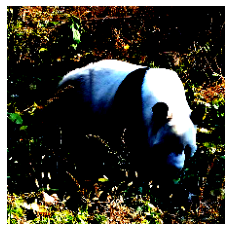

In [10]:
# Build model
tf.keras.backend.clear_session()
model = effnetv2_model.EffNetV2Model(model_name=MODEL)
_ = model(tf.ones([1, 224, 224, 3]), training=False)
model.load_weights(chkpts_path)
cfg = model.cfg

# Run inference for a given image
import preprocessing
image = tf.io.read_file(str(IMAGES_PATH))
image = preprocessing.preprocess_image(
    image, cfg.eval.isize, is_training=False, augname=cfg.data.augname)
logits = model(tf.expand_dims(image, 0), False)

# Output classes and probability
pred = tf.keras.layers.Softmax()(logits)
idx = tf.argsort(logits[0])[::-1][:5].numpy()
import ast
classes = ast.literal_eval(open(LABELS_PATH, "r").read())
for i, id in enumerate(idx):
    print(f'top {i+1} ({pred[0][id]*100:5.1f}%):  {classes[id]} ')
# from IPython import display
# display.display(display.Image(IMAGES_PATH))
fig = plt.figure(facecolor='w', edgecolor='k', frameon=False)
ax = fig.add_subplot(111)
# plt.imshow(img_opencv[0])
plt.imshow(image)
_ = ax.set_aspect('equal')
ax.set_axis_off()
plt.show()